## Setup and Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Project/1. Forecast/household_power_consumption.csv")

## Initial Data Preprocessing

In [ ]:
df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"])
df = df.set_index("timestamp")
df = df.sort_index()

/tmp/ipython-input-2797048051.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"])


In [ ]:
# Ensure numeric type for target variable
df["Global_active_power"] = pd.to_numeric(df["Global_active_power"], errors="coerce")

## Resample to Hourly Data

In [ ]:
# --- Hourly Aggregation (mean consumption per hour) ---
df_hourly = df["Global_active_power"].resample("H").mean()

/tmp/ipython-input-2088105111.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df["Global_active_power"].resample("H").mean()


In [ ]:
# Handle missing hours
df_hourly = df_hourly.interpolate()

In [ ]:
print("Hourly series shape:", df_hourly.shape)

Hourly series shape: (17477,)


## Train-Test Split

In [ ]:
# --- Train–Test Split (time-aware) ---
train_size = int(len(df_hourly) * 0.8)
train = df_hourly.iloc[:train_size]
test  = df_hourly.iloc[train_size:]

print("Train points:", len(train))
print("Test points:", len(test))

Train points: 13981
Test points: 3496


## Naive Forecast Implementation

In [ ]:
# --- Naive Forecast (last observed value) ---
# forecast[t] = value at t-1
naive_forecast = test.shift(1)
naive_forecast.iloc[0] = train.iloc[-1]

## Evaluate Naive Forecast

In [ ]:
mae  = mean_absolute_error(test, naive_forecast)
rmse = np.sqrt(mean_squared_error(test, naive_forecast))
mape = (abs((test - naive_forecast) / test).mean()) * 100

In [ ]:
print("\nNaive Forecast Results (Hourly)")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")


Naive Forecast Results (Hourly)
MAE  : 0.3755
RMSE : 0.6237
MAPE : 41.54%


## Visualize Naive Forecast

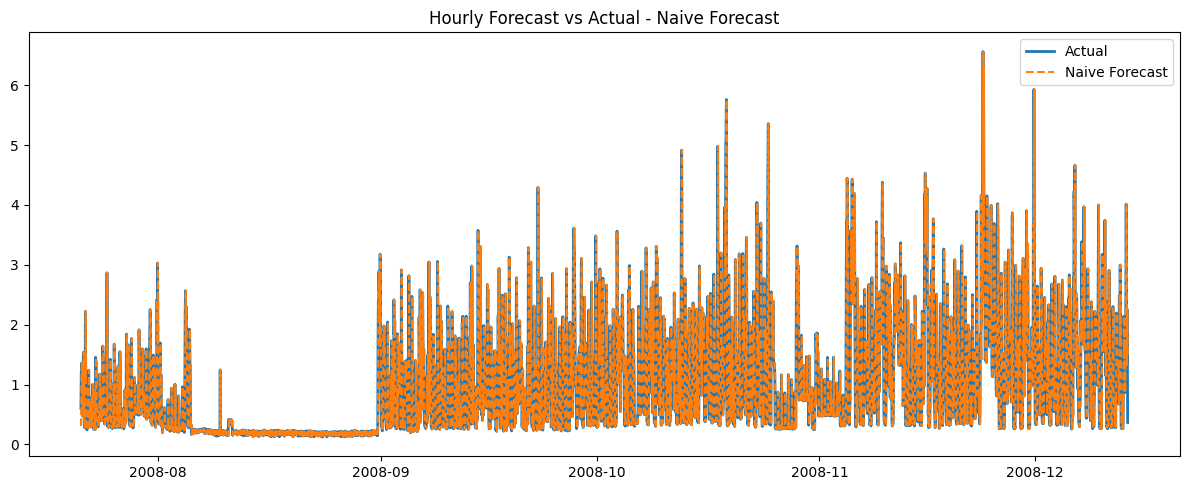

In [ ]:
# Plot forecast vs actual
plt.figure(figsize=(12,5))
plt.plot(test.index, test, label="Actual", linewidth=2)
plt.plot(test.index, naive_forecast, label="Naive Forecast", linestyle="--")
plt.title("Hourly Forecast vs Actual - Naive Forecast")
plt.legend()
plt.tight_layout()
plt.show()

## Predict Next Hour's Consumption

In [ ]:
next_hour_prediction = df_hourly.iloc[-1]

print("Next hour predicted Global Active Power:", next_hour_prediction)

Next hour predicted Global Active Power: 0.3671282051282051


In [ ]:
results_df = pd.DataFrame({
    "Actual": test,
    "Naive_Prediction": naive_forecast
})

results_df.head()

,Actual,Naive_Prediction
timestamp,,
2008-07-21 06:00:00,0.601167,0.306233
2008-07-21 07:00:00,1.161033,0.601167
2008-07-21 08:00:00,1.356633,1.161033
2008-07-21 09:00:00,1.332733,1.356633
2008-07-21 10:00:00,0.669400,1.332733
